# Creating a Simple Model
Before adding a new model, please read the [contribution guidelines](https://github.com/pybamm-team/PyBaMM/blob/master/CONTRIBUTING.md)

In this notebook, we will run through the steps involved in creating a new model within pybamm. We will then solve and plot the outputs of the model. We have choosen to implement a very simple model of SEI growth. We first give a brief derivation of the model and discuss how to nondimensionalise the model so that we can show the full process of model conception to solution within a single notebook.  

Note: if you run the entire notebook and then try to evaluate the ealier cells, you will likely recieve an error. This is becuase the state of objects is mutated as it is passed through various processing. In this case, we recommend that you restart the Kernal and then evaluate cells in turn through the notebook. 

## A Simple Model of Solid Electrolyte Interphase (SEI) Growth

The SEI is a porous layer that forms on the surfaces of negative electrode particles from the products of electrochemical reactions which consume lithium and electrolyte solvents. In the first few cycles of use, a lithium-ion battery loses a large amount of capacity; this is generally attributed to lithium being consumed to produce SEI. However, after a few cycles, the rate of capacity loss slows at a rate often (but not always) reported to scale with the square root of time. SEI growth is therefore often considered to be limited in some way by a diffusion process.

### Dimensional Model

We shall first state our model in dimensional form but to enter the model in pybamm, we strongly recommend converting models into dimensionless form. The main reason for this is that dimensionless models are typically better conditioned than dimensional models and so several digits of accuracy can be gained. To distinguish between the dimensional and dimensionless models, we shall always employ a superscript $*$ on dimensional variables. 

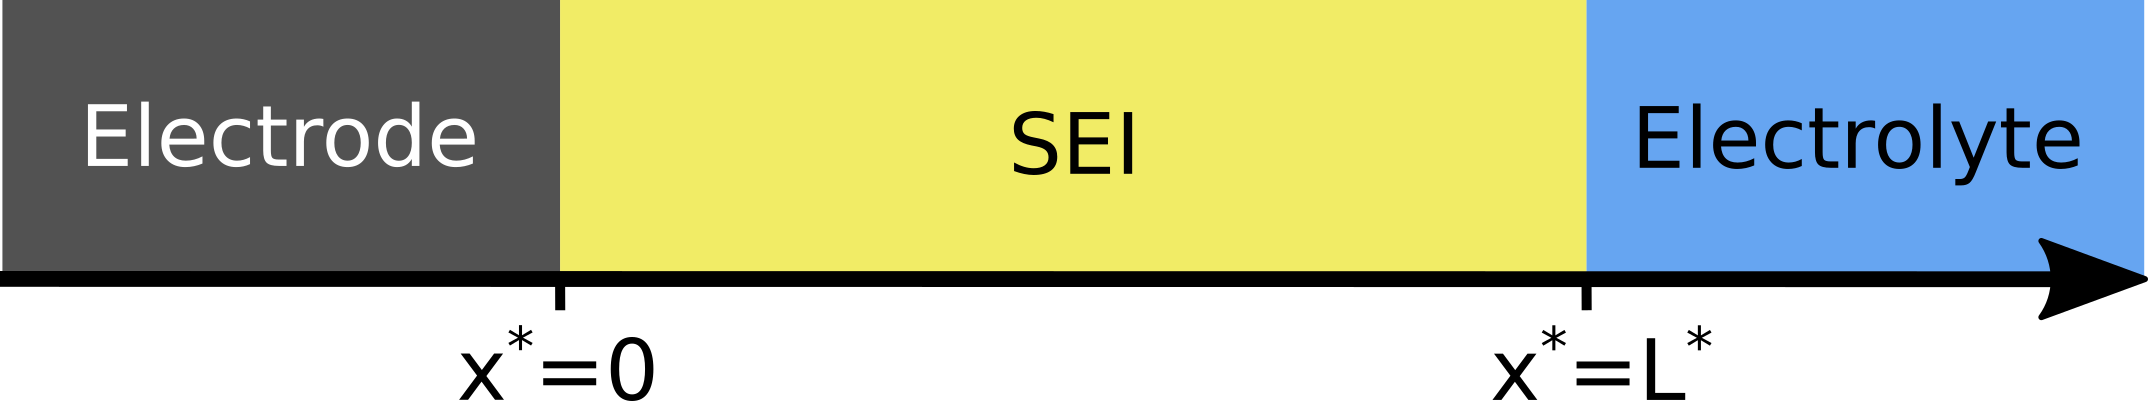

In our simple SEI model, we consider a one-dimensional SEI which extends from the surface of a planar negative electrode at $x^*=0$ until $x^*=L^*$, where $L^*$ is the thickness of the SEI. Since the SEI is porous, there is some electrolyte within the region $x^*\in[0, L^*]$ and therefore some concentration of solvent, $c^*$. Within the porous SEI, the solvent is transported via a diffusion process according to:
$$
\frac{\partial c^*}{\partial t^*} = - \nabla^* \cdot N^*, \quad N^* = - D^*(c^*) \nabla^* c^* \label{dim:eqn:solvent-diffusion}\tag{1}\\
$$
where $t^*$ is the time, $N^*$ is the solvent flux, and $D^*(c^*)$ is the effective solvent diffusivity (a function of the solvent concentration).

On the electrode-SEI surface ($x^*=0$) the solvent is consumed by the SEI growth reaction, $R^*$. We asssume that diffusion of solvent in the bulk electrolyte ($x^*>L^*$) is fast so that on the SEI-electrolyte surface ($x^*=L^*$) the concentration of solvent is fixed at the value $c^*_{\infty}$. Therefore, the boundary conditions are
$$
    N^*|_{x^*=0} = - R^*, \quad c^*|_{x^*=L^*} = c^*_{\infty},
$$
We also assume that the concentration of solvent within the SEI is initially uniform and equal to the bulk electrolyte solvent concentration, so that the initial condition is
$$
   c^*|_{t^*=0} = c^*_{\infty}
$$

Since the SEI is growing, we require an additional equation for the SEI thickness. The thickness of the SEI grows at a rate proportial to the SEI growth reaction $R^*$, where the constant of proportionality is the partial molar volume of the reaction products, $\hat{V}^*$. We also assume that the SEI is initially of thickness $L^*_0$. Therefore, we have
$$
    \frac{d L^*}{d t^*} = \hat{V}^* R^*, \quad L^*|_{t^*=0} = L^*_0
$$

Finally, we assume for the sake of simplicity that the SEI growth reaction is irreverisble and that the potential difference across the SEI is constant. The reaction is also assumed to be proportional to the concentration of solvent at the electrode-SEI surface ($x^*=0$). Therefore, the reaction flux is given by
$$
 R^* = k^* c^*|_{x^*=0}
$$
where $k^*$ is the reaction rate constant (which is in general dependent upon the potential differnce across the SEI).

### Non-dimensionalisation

To convert the model into dimensionless form, we scale the dimensional variables and dimensional functions. For this model, we choose to scale $x^*$ by the current SEI thickness, the current SEI thickness by the initial SEI thickness, solvent concentration with the bulk electrolyte solvent concentration, and the solvent diffusion with the solvent diffusion in the electrolyte. We then use these scalings to infer the scaling for the solvent flux. Therefore, we have
$$
x^* = L^* x, \quad L^*= L^*_0 L \quad c^* = c^*_{\infty} c, \quad D^*(c^*) = D^*(c^*_{\infty}) D(c), \quad  
N^* = \frac{D^*(c^*_{\infty}) c^*_{\infty}}{L^*_0}N.
$$
We also choose to scale time by the solvent diffusion timescale so that 
$$
t^* = \frac{(L^*_0)^2}{D^*(c^*_{\infty})}t.
$$
Finally, we choose to scale the reaction flux in the same way as the solvent flux so that we have
$$
    R^* = \frac{D^*(c^*_{\infty}) c^*_{\infty}}{L^*_0} R.
$$

We note that there are multiple possible choices of scalings. Whilst they will all give the ultimately give the same answer, some choices are better than others depending on the situation under study.

### Dimensionless Model

After substituting in the scalings from the previous section, we obtain the dimensionless form of the model given by:

Solvent diffusion through SEI:
\begin{align}
\frac{\partial c}{\partial t} = \frac{\hat{V} R}{L} x \cdot \nabla c - \frac{1}{L}\nabla \cdot N, \quad N = - \frac{1}{L}D(c) \nabla c, \label{eqn:solvent-diffusion}\tag{1}\\
N|_{x=0} = - R, \quad c|_{x=1} = 1  \label{bc:solvent-diffusion}\tag{2} \quad
c|_{t=0} = 1; 
\end{align}

Growth reaction:
$$
R = k c|_{x=0}; \label{eqn:reaction}\tag{3}
$$

SEI thickness:
$$
\frac{d L}{d t} = \hat{V} R, \quad L|_{t=0} = 1; \label{eqn:SEI-thickness}\tag{4}
$$
where the dimensionless parameters are given by
$$
 k = \frac{k^* L^*_0}{D^*(c^*_{\infty})}, \quad \hat{V} = \hat{V}^* c^*_{\infty}, \quad 
 D(c) = \frac{D^*(c^*)}{D^*(c^*_{\infty})}.  \label{parameters}\tag{5}
$$
In the above, the additional advective term in the diffusion equation arises due to our choice to scale the spatial coordinate $x^*$ with the time-dependent SEI layer thickness $L^*$.

## Converting the Model into PyBaMM

As always, we begin by importing pybamm and changing our working directory to the root of the pybamm folder.

In [1]:
import pybamm
import numpy as np
import os
os.chdir(pybamm.__path__[0]+'/..')

A model is defined in six steps:
1. Initialise model
2. Define parameters and variables
3. State governing equations
4. State boundary conditions
5. State initial conditions
6. State output variables

We shall proceed through each step to enter our simple SEI growth model.

#### 1. Initialise model

We first initialise the model using the `BaseModel` class. This sets up the required structure for our model. 

In [2]:
model = pybamm.BaseModel()

#### 2. Define parameters and variables

In our SEI model, we have two dimensionless parameters: $k$ and $\hat{V}$ aswell as one dimensionless function $D(c)$ which are given in terms of the dimensional parameters, see (5). In pybamm, inputs are dimensional so we first state all the dimensional parameters and then define the dimensionless parameters in terms of them. To define the dimensional parameters, we use the `Parameter` to create parameter symbols. Parameters which are functions are defined using  `FunctionParameter` and should be defined within a python function as shown. 

In [3]:
# dimensional parameters
k_dim = pybamm.Parameter("Reaction rate constant")
L_0_dim = pybamm.Parameter("Initial thickness")
V_hat_dim = pybamm.Parameter("Partial molar volume")
c_inf_dim = pybamm.Parameter("Bulk electrolyte solvent concentration")

def D_dim(cc):
    return pybamm.FunctionParameter("Diffusivity", cc)

# dimensionless parameters
k = k_dim * L_0_dim / D_dim(c_inf_dim)
V_hat = V_hat_dim * c_inf_dim

def D(cc):
    c_dim = c_inf_dim * cc
    return D_dim(c_dim) / D_dim(c_inf_dim)

We now define the dimensionless variables in our model. Since we solve for these, we do not need to write them in terms of the dimensional variables. We simply use `SpatialVariable` and `Variable` to create the required symbols: 

In [4]:
x = pybamm.SpatialVariable("x", domain="SEI layer", coord_sys="cartesian")
c = pybamm.Variable("Solvent concentration", domain="SEI layer")
L = pybamm.Variable("SEI thickness")

#### 3. State governing equations

We can now use the symbols we have created for our parameters and variables to write out our governing equations. Note that before we use the reaction flux and solvent flux, we must derive new symbols for them from the defined parameter and variable symbols. Each governing equation must also be stated in the form `d/dt = rhs` since pybamm only stores the right hand side (rhs) and assumes that the left hand side is the time derivative. The govenering equations are then simply

In [5]:
# SEI reaction flux
R = k * pybamm.BoundaryValue(c, "left")

# solvent concentration equation
N = - (1 / L) * D(c) * pybamm.grad(c)
dcdt = (V_hat * R) * pybamm.inner(x / L, pybamm.grad(c)) - (1 / L) * pybamm.div(N)

# SEI thickness equation
dLdt = V_hat * R

Once we have stated the equations, we can add them to the `model.rhs` dictionary. This is a dictionary which stores the right had sides of the governing equations. Each key in the dictionary corresponds to the variable which the equation is being solved for.

In [6]:
model.rhs = {c: dcdt, L: dLdt}

#### 4. State boundary conditions

We only have boundary conditions on the solvent concentration equation. We must state where a condition is Neumann (on the gradient) or Dirichlet (on the variable itself). 

The boundary condition on the electrode-SEI (x=0) boundary is: 
$$
    N|_{x=0} = - R, \quad  N|_{x=0} = - \frac{1}{L} D(c|_{x=0} )\nabla c|_{x=0}
$$
which is a Neumann condition. To implement this boundary condition in pybamm, we must first rearrange the equation so that the gradient of the concentration, $\nabla c|_{x=0}$, is the subject. Therefore we have
$$
    \nabla c|_{x=0} = \frac{L R}{D(c|_{x=0} )}
$$
which we enter into pybamm as   

In [7]:
# electrode-SEI boundary condition (x=0) (lbc = left boundary condition)
D_left = pybamm.BoundaryValue(D(c), "left") # pybamm requires BoundaryValue(D(c)) and not D(BoundaryValue(c)) 
grad_c_left = L * R / D_left

On the SEI-electrolyte boundary (x=1), we have the boundary condition
$$
    c|_{x=1} = 1
$$

which is a Dirichlet condition and is just entered as

In [8]:
c_right = pybamm.Scalar(1)

We now load these boundary conditions into the `model.boundary_conditions` dictionary in the following way, being careful to state the type of boundary condition: 

In [9]:
model.boundary_conditions = {c: {"left": (grad_c_left, "Neumann"), "right": (c_right, "Dirichlet")}}

#### 5. State initial conditions

There are two initial conditions in our model:
$$
    c|_{t=0} = 1, \quad L|_{t=0} = 1
$$

which are simply written in pybamm as

In [10]:
c_init = pybamm.Scalar(1)
L_init = pybamm.Scalar(1)

and then included into the `model.initial_conditions` dictionary:

In [11]:
model.initial_conditions = {c: c_init, L: L_init}

#### 6. State output variables

We already have everything required in model for the model to be used and solved but we have not yet stated what we actually want to output from the model. PyBaMM allows users to output any combination of symbols as an output variable therefore allowing the user the flexibility to output important quanities without further tedious postprocessing steps. 

Some useful outputs for this simple model are:
- the SEI thickness
- the SEI growth rate
- the solvent concentration

These are added to the model by simply entering

In [12]:
model.variables = {"SEI thickness": L, "SEI growth rate": dLdt, "Solvent concentration": c}

We can also output the dimensional versions of these variables by multiplying by the scalings in the Non-dimensionalisation section. By convention, we recommend include in the units in the output variables name so that they do not overwrite the dimensionless output variables. We also `.update` the disctionary so that we add to the previous output variables.

In [13]:
L_dim = L_0_dim * L
dLdt_dim = (D_dim(c_inf_dim) / L_0_dim ) * dLdt
c_dim = c_inf_dim * c

model.variables.update({
                        "SEI thickness [m]": L_dim, 
                        "SEI growth rate [m/s]": dLdt_dim, 
                        "Solvent concentration [mols/m^3]": c_dim
                        }
                      )


And thats it, the model is fully defined and ready to be used. If you plan on reusing the model several times, you can additionally set model defaults which include: a default geometry to run the model on, a default set of parameter values, a default solver, etc.

## Using the Model

The model will now behave in the same way as any of the inbuilt PyBaMM models. However, to demonstrate that the model works we display the steps involved in solving the model but we will not go into details within this notebook.

In [14]:
# define geometry
geometry = pybamm.Geometry()
geometry.add_domain("SEI layer", {"primary": {x: {"min": pybamm.Scalar(0), "max": pybamm.Scalar(1)}}})

def Diffusivity(cc):
    return cc * 10**(-5)

# parameter values (not physically based, for example only!)
param = pybamm.ParameterValues(
    {
        "Reaction rate constant": 20,
        "Initial thickness": 1e-6,
        "Partial molar volume": 10,
        "Bulk electrolyte solvent concentration": 1,
        "Diffusivity": Diffusivity,
    }
)

# process model and geometry
param.process_model(model)
param.process_geometry(geometry)

# mesh and discretise
submesh_types = {"SEI layer": pybamm.Uniform1DSubMesh}
var_pts = {x: 100}
mesh = pybamm.Mesh(geometry, submesh_types, var_pts)
                   
spatial_methods = {"SEI layer": pybamm.FiniteVolume()}
disc = pybamm.Discretisation(mesh, spatial_methods)
disc.process_model(model)

# solve
solver = pybamm.ScipySolver()
t = np.linspace(0, 100, 100)
solution = solver.solve(model, t)

# Extract output variables
L_out = pybamm.ProcessedVariable(
    model.variables["SEI thickness"], solution.t, solution.y, mesh
)
c_out = pybamm.ProcessedVariable(
    model.variables["Solvent concentration"], solution.t, solution.y, mesh
)
x = np.linspace(0, 1, 100)

Using these outputs, we can now plot the SEI thickness as a function of time and also the solvent concentration profile within the SEI. We use a slider to plot the concentration profile at different times.

In [15]:
import matplotlib.pyplot as plt
def plot(t):
    f, (ax1, ax2) = plt.subplots(1, 2 ,figsize=(10,5))
    ax1.plot(solution.t, L_out(solution.t))
    ax1.plot([t], [L_out(t)], 'r.')
    plot_c, = ax2.plot(x * L_out(t), c_out(t, x))
    ax1.set_ylabel('SEI thickness')
    ax1.set_xlabel('t')
    ax2.set_ylabel('Solvent concentration')
    ax2.set_xlabel('x')
    ax2.set_ylim(0, 1.1)
    ax2.set_xlim(0, x[-1]*L_out(solution.t[-1]))
    plt.show()
    
import ipywidgets as widgets
widgets.interact(plot, t=widgets.FloatSlider(min=0,max=solution.t[-1],step=0.1,value=0));

interactive(children=(FloatSlider(value=0.0, description='t'), Output()), _dom_classes=('widget-interact',))

## Formally adding your model

The purpose of this notebook has been to go through the steps involved in getting a simple model working within PyBaMM. However, if you plan on reusing your model and want greater flexibility then we recommend that you create a new class for your model. We have set out instructions on how to do this in the "Adding a Model" tutorial in the documentation. 